In [1]:
# Import libraries
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pyvin
import re


from dotenv import load_dotenv
from shapely.geometry import shape
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sodapy import Socrata
from tqdm.auto import tqdm

tqdm.pandas()

In [4]:
def run_client(client_url):
    '''
    Input:
        - Client URL
    Output:
        - Client data for New York State API
    '''
    #Load enviroment file
    load_dotenv()
    
    # Login to NYS data with enviornment data
    client = Socrata(client_url,
                 'nys_app_token',
                 username = 'nys_key_id',
                 password = 'nys_key_password')
    return client

def load_dmv_api(client_url):
    '''
    Input:
        - N/A
    Output:
        - Dataframe with all vehicle registrations in New York that have not expired two years ago
            - The data frame includes only vehicles from New York City that are electric
    '''
    
    # Set up endpoint
    endpoint = 'w4pv-hbkt'
    
    # Get client information
    client = run_client(client_url)
    
    # Get total number of records in api
    query_count = "SELECT COUNT(*)"
    ### CHANGE VALUE BASED ON IF YOU ARE TESTING###
    # NUM_RECORDS = 1000
    NUM_RECORDS = int(client.get(endpoint, query = query_count)[0]['COUNT'])
    
    # Set up query for api. Select only only vehicles from New York City that are electric
    query = f"""
        SELECT vin, county, zip
        WHERE record_type = 'VEH'
        AND county in ('NEW YORK')
        AND fuel_type = 'ELECTRIC'
        LIMIT {NUM_RECORDS}
    """
    #
    
    # Pull results from DMV registration that are vehicles
    results = client.get(endpoint, query=query)
    
    # Change results into dataframe
    return pd.DataFrame.from_records(results)

def load_zip_api(client_url):
    '''
    Input:
        - N/A
    Output:
        - Dataframe with NYC zipcodes 
    '''
    
    # Set up endpoint
    endpoint = 'pri4-ifjk'
    
    # Get client information
    client = run_client(client_url)
    
    # Get total number of records in api
    query_count = "SELECT COUNT(*)"
    NUM_RECORDS = int(client.get(endpoint, query = query_count)[0]['COUNT'])
    
    # Set up query for api. Select only only vehicles from New York City that are electric
    query = f"""
        SELECT *
        LIMIT {NUM_RECORDS}
    """
    #
    
    # Pull results from DMV registration that are vehicles
    results = client.get(endpoint, query=query)
    
    # Change results into dataframe
    return pd.DataFrame.from_records(results)

In [5]:
# Load dataset with vin numbers of NYS registered vehicles
df_dmv = load_dmv_api('data.ny.gov')

# Get only vins with the correct number of digits for a person vehicle
df_dmv = df_dmv.loc[df_dmv['vin'].str.len() == 17].copy()

# Drop nan
df_dmv.dropna(inplace = True)

# Set each row to specified datatype
df_dmv['vin'] = df_dmv['vin'].astype(str)
df_dmv['county'] = df_dmv['county'].astype(str)
df_dmv['zip'] = df_dmv['zip'].astype(int)

In [ ]:
# Change vin numbers to models
df_dmv['model'] = df_dmv['vin'].progress_apply(lambda x: pyvin.VIN(x, error_handling=pyvin.PASS).Model)

In [6]:
# Load csv from previous pyvin determination
df_dmv = pd.read_csv('ev_with_models.csv')

df_dmv.dropna(subset = ['model'], inplace = True)

In [7]:
# Load emission & range data for epa registered vehicles
df_veh_range = pd.read_csv('https://www.fueleconomy.gov/feg/epadata/vehicles.csv', low_memory=False)

In [8]:
# Change values to float
def func_to_numeric(x):
    return pd.to_numeric(x, errors = 'coerce')
df_veh_range[['range','rangeCity','rangeCityA','rangeHwy','rangeHwyA','rangeA']] = df_veh_range[['range','rangeCity','rangeCityA','rangeHwy','rangeHwyA','rangeA']].apply(func_to_numeric)

# Get mean of vehicle ranges
df_veh_range['max_range'] = df_veh_range[['range','rangeCity','rangeCityA','rangeHwy','rangeHwyA','rangeA']].max(axis = 1)

# Get only the model and vehicle range
df_veh_range = df_veh_range[['model','max_range']]

# Drop vehicles without fuel range
df_veh_range.dropna(subset=['max_range'], inplace = True)

# Group model duplicates and take the max of the duplicates
df_veh_range = df_veh_range.groupby('model').max().reset_index()

# Sort ranges by model names
df_veh_range.sort_values(by = ['model'], inplace = True)

In [9]:
# Create a dictionary with models and trims
tracker_dict = {}
def get_model_range(model):
    df = df_veh_range[df_veh_range['model'].str.contains(model, flags=re.IGNORECASE)]
    tracker_dict[model] = df['model'].unique()
    return df.max_range.agg({'avg_range': 'mean', 'median_range':'median', 'std_range':'std'})

In [10]:
# Create dataframe with unique models
unique_models = pd.DataFrame(df_dmv.model.unique(), columns=['model'])

# Set blanks to nan in model names
unique_models = unique_models[unique_models['model'] != '']

# Dataframe with unique models and ranges
unique_models_and_ranges = pd.concat([unique_models,
                           unique_models.model.apply(lambda model: get_model_range(model))],
                           axis=1)

# Drop models without an average name or if model is blank
unique_models_and_ranges.dropna(subset=['model','avg_range'], inplace = True)

#Merge dmv information with model ranges
df_dmv_with_ranges = df_dmv.merge(unique_models_and_ranges, how='left', on='model')

# Drop values if no average range was found
df_dmv_with_ranges.dropna(subset=['avg_range'], inplace = True)

df_dmv_with_ranges = df_dmv_with_ranges[df_dmv_with_ranges['avg_range'] != 0]

# Create dataframe with average range, median range, and standard deviation of each zipcode
df_zip_ranges = df_dmv_with_ranges[['zip','avg_range','median_range','std_range']].groupby(by=['zip'], as_index = False).mean()

# Add random distribution sample to dataframe
df_zip_ranges['sample_range'] = np.random.normal(df_zip_ranges['avg_range'],df_zip_ranges['std_range'])

/tmp/ipykernel_3776/3758231243.py:4: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df = df_veh_range[df_veh_range['model'].str.contains(model, flags=re.IGNORECASE)]


In [11]:
# Load zipcode data
zip_df = load_zip_api('data.cityofnewyork.us')

# Change geometry into shaply object
zip_df['geometry'] = zip_df['the_geom'].apply(lambda x: shape(x))

# Convert dataframe into geopandas dataframe
gdf_zip = gpd.GeoDataFrame(zip_df, geometry = 'geometry', crs = 'EPSG:4326')

# Set modzcta to integer datatype
gdf_zip['modzcta'] = gdf_zip['modzcta'].astype(int)

In [12]:
# Dataframe with geom data and sample range
gdf_plot = pd.merge(gdf_zip, df_zip_ranges, left_on='modzcta', right_on='zip')

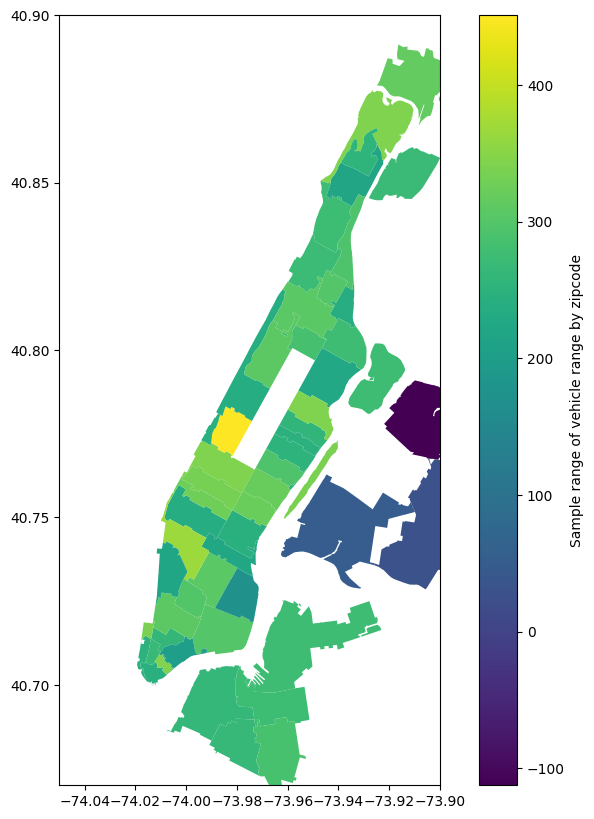

In [18]:
# Plot vehicle ranges by zipcode
gdf_plot.plot(column = 'sample_range', legend = True, legend_kwds = {'label': "Sample range of vehicle range by zipcode"}, figsize = (10,10))
plt.xlim([-74.05,-73.9])
plt.ylim([40.67,40.9])
plt.show()

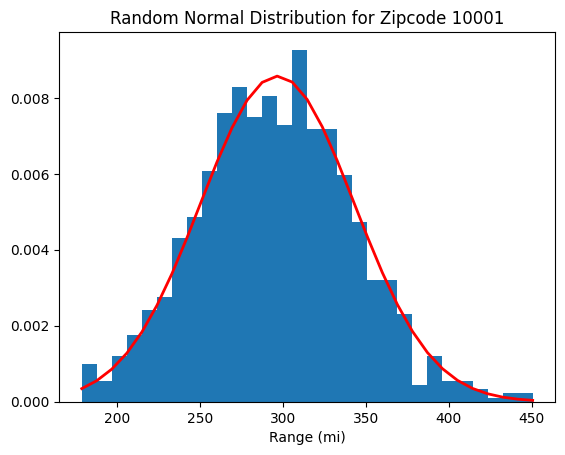

In [14]:
# Example distribution plot
mu = df_zip_ranges['avg_range'][0]
sigma = df_zip_ranges['std_range'][0]
s= np.random.normal(mu,sigma,1000)

count, bins, ignored = plt.hist(s, 30, density=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r')
plt.title('Random Normal Distribution for Zipcode 10001')
plt.xlabel('Range (mi)')
plt.show()